## **Support Ticket Cateogrization**

### By Noor Aftab###

### **Business Context**

In today's dynamic business landscape, organizations are increasingly recognizing the pivotal role customer feedback plays in shaping the trajectory of their products and services. The ability to **swiftly and effectively respond to customer input** not only fosters enhanced customer experiences but also serves as a catalyst for growth, prolonged customer engagement, and the nurturing of lifetime value relationships.

As a dedicated Product Manager, staying attuned to the voice of your customers is not just a best practice; it's a strategic imperative.

While your organization may be inundated with a wealth of customer-generated feedback and support tickets, your role entails much more than just processing these inputs. To make your efforts in managing customer experience and expectations truly impactful, you need a structured approach – a method that allows you to discern the most pressing issues, set priorities, and allocate resources judiciously.

One of the most effective strategies at your disposal as an organization is to harness the power of automated Support Ticket Categorization - **done in the modern day using Large Language Models and Generative AI.**


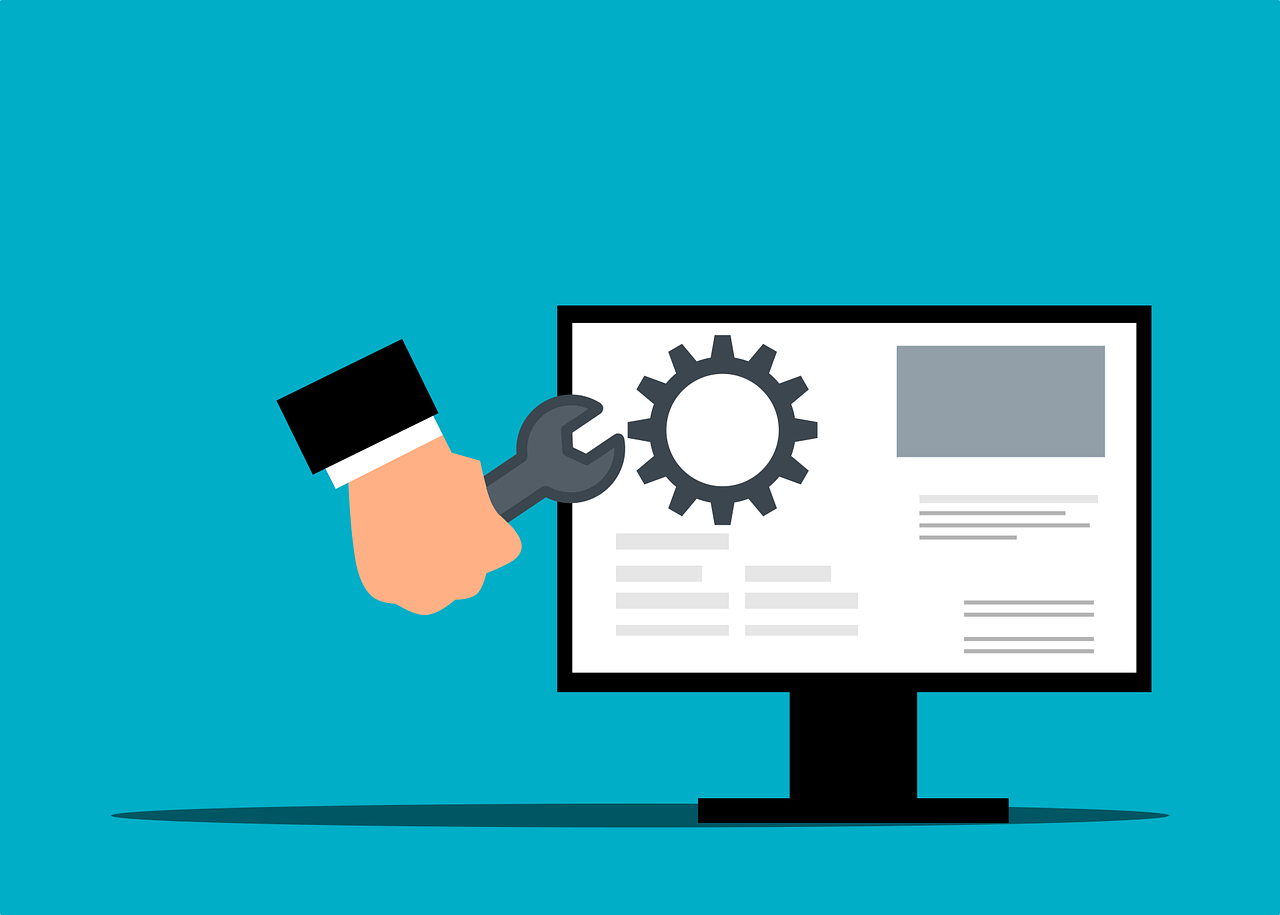

### **Objective**

Develop a Generative AI application using a Large Language Model to **automate the classification and processing of support tickets.** The application will aim to predict ticket categories, assign priority, suggest estimated resolution times, generate responses based on sentiment analysis, and store the results in a structured DataFrame.


## **Installing and Importing Necessary Libraries and Dependencies**

In [2]:
# Installation for GPU llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.45 --force-reinstall --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 289.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 333.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 249.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 269.6 MB/s eta 0:00:00


In [ ]:
# For downloading the models from HF Hub
!pip install huggingface_hub==0.20.3 -q

In [ ]:
# Importing library for data manipulation
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the json module
import json

## **Loading the Dataset**

In [ ]:
#Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the CSV file and storing it in a data varaible
data = pd.read_csv("/content/drive/MyDrive/AI-ML-Capstone/Support_ticket_text_data_mid_term.csv")

## **Data Overview**

In [ ]:
#checking the first 5 rows of the data
data.head()

,support_tick_id,support_ticket_text
0,ST2023-006,My internet connection has significantly slowe...
1,ST2023-007,Urgent help required! My laptop refuses to sta...
2,ST2023-008,I've accidentally deleted essential work docum...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...
4,ST2023-010,"My smartphone battery is draining rapidly, eve..."


In [ ]:
# Write the code to check the shape of the data
data.shape

(21, 2)

###**Observations**###

- Data has 21 rows and 2 columns

In [ ]:
# Checking for missing values in the data
data.isnull().sum()

support_tick_id        0
support_ticket_text    0
dtype: int64

###**Observations**###

- There are no missing values in the data.

## **Model Building**

### Loading the model

In [ ]:
#We will be using the 13B Parameter Llama chat model. This is the Q5 quantized model from the Bloke
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [ ]:
# Using hf_hub_download to download a model from the Hugging Face model hub
model_path = hf_hub_download(
    repo_id = model_name_or_path,
    filename = model_basename
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [ ]:
#Instantiating the Llama model
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=43,  # Change this value based on your model and your GPU VRAM pool.
    n_ctx=4096,  # Context window
)

llama_model_loader: loaded meta data with 19 key-value pairs and 363 tensors from /root/.cache/huggingface/hub/models--TheBloke--Llama-2-13B-chat-GGUF/snapshots/4458acc949de0a9914c3eab623904d4fe999050a/llama-2-13b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 5120
llama_model_loader: - kv   4:                          llama.block_count u32              = 40
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 13824
llama_model_loader: - kv   6:                 llama.rope.dimension_

### Defining Model Response Parameters

In [ ]:
def generate_llama_response(instruction, review):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{review}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1024, #specifies maximum number of tokens that the model should generate
        temperature=0.01, #controls the *randomness* of the response. Higher temprature gives more random the response while lower gives predictable responses
        top_p=0.95, # controls the diversity in response. Higher the top_p: the more diverse the response
        repeat_penalty=1.2, #A higher repeat penalty results in lower probability of repeating the tokens
        top_k=50, #controls the max no of most-likely next tokens to considers
        stop=['INST'],
        echo=False, #controls whether input prompt to the model should be returned in model response
        seed=42, # parameter helps replicate results
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]
    return response_text

## **Task 1: Ticket Categorization**

In [ ]:
# create a copy of the data
data_1 = data.copy()

In [ ]:
## In instruction 1, we are extracting the category of support ticket
instruction_1 = """
    You are analyzing support tickets.
    Analyze the provided support ticket text and determine the most appropriate category for the issue described.
   Choose from the following categories: Hardware Issues, Software Issues, Data Recovery, Technical Issues, or Other. Provide the category that best matches the content of the support ticket.
"""


In [ ]:
data_1['llama_response'] = data_1['support_ticket_text'].apply(lambda x: generate_llama_response(instruction_1,x))


llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      33.83 ms /    58 runs   (    0.58 ms per token,  1714.35 tokens per second)
llama_print_timings: prompt eval time =     585.88 ms /   151 tokens (    3.88 ms per token,   257.73 tokens per second)
llama_print_timings:        eval time =    2644.97 ms /    57 runs   (   46.40 ms per token,    21.55 tokens per second)
llama_print_timings:       total time =    3422.91 ms /   208 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      24.52 ms /    45 runs   (    0.54 ms per token,  1835.01 tokens per second)
llama_print_timings: prompt eval time =     448.18 ms /   149 tokens (    3.01 ms per token,   332.46 tokens per second)
llama_print_timings:        eval time =    2070.08 ms /    44 runs   (   47.05 ms per token,    21.26 tokens per second)
llama_print_timings:       total time =    2649.31 ms /   193 

In [ ]:
# Checking the first five rows of the data to confirm whether the new column has been added
data_1.head()

,support_tick_id,support_ticket_text,llama_response
0,ST2023-006,My internet connection has significantly slowe...,Based on the information provided in the supp...
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Based on the information provided in the supp...
2,ST2023-008,I've accidentally deleted essential work docum...,Based on the content of the provided support ...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Based on the information provided in the supp...
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Sure! Based on the content of the support tic...


In [ ]:
#This function will check for the category and return the value
def extract_category(model_response):
    if 'technical issues' in model_response.lower():
        return 'Technical issues'
    elif 'hardware issues' in model_response.lower():
        return 'Hardware issues'
    elif 'data recovery' in model_response.lower():
        return 'Data recovery'

In [ ]:
# Extract category of each row and store it in Category column
data_1['Category'] = data_1['llama_response'].apply(extract_category)

#checking first five rows to ensure that the function is working
data_1['Category'].head()

0    Technical issues
1     Hardware issues
2       Data recovery
3    Technical issues
4     Hardware issues
Name: Category, dtype: object

In [ ]:
#cleaning the final output by dropping the model response.

final_data_1 = data_1.drop(['llama_response'], axis=1)
final_data_1.head()

,support_tick_id,support_ticket_text,Category
0,ST2023-006,My internet connection has significantly slowe...,Technical issues
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware issues
2,ST2023-008,I've accidentally deleted essential work docum...,Data recovery
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Technical issues
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware issues


## **Task 2: Ticket Categorization and Returning Structured Output**

In [ ]:
# create a copy of the data
data_2 = data.copy()

In [ ]:
## The goal of the second instruction is two fold 1] Classify tickets to categories and 2] Create JSON key value pair of caterogy
instruction_2 = """
       You are an AI analyzing support tickets reviews. Classify support ticket into the following categories:

    - Hardware Issues
    - Software Issues
    - Technical Issues
    - Data Recovery
    - Other

    Provide the category that best matches the content of the support ticket.

    Format the output as a JSON object with a single key-value pair as shown below:
    {"Category": "your_category_prediction"}
"""


In [ ]:
# This code will create a column : llama_response by applying the generate_llama_response function to each ticket in the 'support_ticket_text' column of the DataFrame
data_2['llama_response'] = data_2['support_ticket_text'].apply(lambda x: generate_llama_response(instruction_2,x))

Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      43.32 ms /    77 runs   (    0.56 ms per token,  1777.35 tokens per second)
llama_print_timings: prompt eval time =     564.17 ms /   180 tokens (    3.13 ms per token,   319.05 tokens per second)
llama_print_timings:        eval time =    4103.86 ms /    76 runs   (   54.00 ms per token,    18.52 tokens per second)
llama_print_timings:       total time =    4908.74 ms /   256 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      46.04 ms /    83 runs   (    0.55 ms per token,  1802.66 tokens per second)
llama_print_timings: prompt eval time =     518.78 ms /   179 tokens (    2.90 ms per token,   345.04 tokens per second)
llama_print_timings:        eval time =    4615.88 ms /    82 runs   (   56.29 ms per token,    17.76 tokens per second)
llama_print_timings:       to

In [ ]:
# Checking the first five rows of the data to confirm whether the new column has been added
data_2.head()

,support_tick_id,support_ticket_text,llama_response
0,ST2023-006,My internet connection has significantly slowe...,Sure! Here's my analysis of your support tick...
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"Sure, I can assist you with that! Based on th..."
2,ST2023-008,I've accidentally deleted essential work docum...,"Sure! Based on your support ticket content, I..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Sure! Based on the content of your support ti...
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Sure! I'd be happy to help classify your supp...


In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

In [ ]:
## Extract JSON data in a new column called llama_response_parsed
data_2['llama_response_parsed'] = data_2['llama_response'].apply(extract_json_data)
data_2['llama_response_parsed'].head()

0    {'Category': 'Technical Issues'}
1     {'Category': 'Hardware Issues'}
2       {'Category': 'Data Recovery'}
3    {'Category': 'Technical Issues'}
4     {'Category': 'Hardware Issues'}
Name: llama_response_parsed, dtype: object

In [ ]:
## Normalizing JSON on llama_response_parsed variable into readable text
llama_response_parsed_df_2 = pd.json_normalize(data_2['llama_response_parsed'])
llama_response_parsed_df_2.head()

,Category
0,Technical Issues
1,Hardware Issues
2,Data Recovery
3,Technical Issues
4,Hardware Issues


In [ ]:
## Concat data with model response
data_with_parsed_model_output_2 = pd.concat([data_2, llama_response_parsed_df_2], axis=1)
data_with_parsed_model_output_2.head()

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category
0,ST2023-006,My internet connection has significantly slowe...,Sure! Here's my analysis of your support tick...,{'Category': 'Technical Issues'},Technical Issues
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"Sure, I can assist you with that! Based on th...",{'Category': 'Hardware Issues'},Hardware Issues
2,ST2023-008,I've accidentally deleted essential work docum...,"Sure! Based on your support ticket content, I...",{'Category': 'Data Recovery'},Data Recovery
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Sure! Based on the content of your support ti...,{'Category': 'Technical Issues'},Technical Issues
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Sure! I'd be happy to help classify your supp...,{'Category': 'Hardware Issues'},Hardware Issues


In [ ]:
## Dropping llama_response and llama_response_parsed variables to get clean final response
final_data_2 = data_with_parsed_model_output_2.drop(['llama_response','llama_response_parsed'], axis=1)
final_data_2.head()

,support_tick_id,support_ticket_text,Category
0,ST2023-006,My internet connection has significantly slowe...,Technical Issues
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware Issues
2,ST2023-008,I've accidentally deleted essential work docum...,Data Recovery
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Technical Issues
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware Issues


## **Task 3: Ticket Categorization, Creating Tags, and Returning Structured Output**

In [ ]:
# create a copy of the data
data_3 = data.copy()

In [ ]:
## In the third instruction, we are asking model to classify tickets, generate tags and return JSON key value pairs
instruction_3 = """
    You are an AI analyzing support tickets. For each support ticket, do the following:

    1. Classify the ticket into one of these categories:
       - Hardware Issues
       - Software Issues
       - Technical Issues
       - Data Recovery
       - Other
       Provide the category that best fits the content of the ticket.

    2. Based on the content of the ticket, generate relevant tags. Tags should be keywords or short phrases that capture the main issues or items mentioned in the ticket.

    Format the output as a JSON object with two key-value pairs for the category and tags, as shown below:
    {
      "Category": "your_category_prediction",
      "Tags": ["tag1", "tag2", "tag3"]
    }
"""


In [ ]:
# Create a column : llama_response to store the response form  model
data_3['llama_response'] = data_3['support_ticket_text'].apply(lambda x: generate_llama_response(instruction_3,x))

Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      69.35 ms /   122 runs   (    0.57 ms per token,  1759.24 tokens per second)
llama_print_timings: prompt eval time =     598.09 ms /   255 tokens (    2.35 ms per token,   426.36 tokens per second)
llama_print_timings:        eval time =    6885.35 ms /   121 runs   (   56.90 ms per token,    17.57 tokens per second)
llama_print_timings:       total time =    7894.86 ms /   376 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      73.36 ms /   131 runs   (    0.56 ms per token,  1785.64 tokens per second)
llama_print_timings: prompt eval time =     585.54 ms /   254 tokens (    2.31 ms per token,   433.79 tokens per second)
llama_print_timings:        eval time =    7474.48 ms /   130 runs   (   57.50 ms per token,    17.39 tokens per second)
llama_print_timings:       to

In [ ]:
# Checking the first five rows of the data to confirm whether the new column has been added
data_3.head()

,support_tick_id,support_ticket_text,llama_response
0,ST2023-006,My internet connection has significantly slowe...,Sure! I'd be happy to help you classify and t...
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"Sure, I can assist you with that! Here is the..."
2,ST2023-008,I've accidentally deleted essential work docum...,Sure! I can help you with that. Here is the c...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Sure! I'd be happy to assist you with that. H...
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Sure! I'd be happy to help analyze your suppo...


In [ ]:
## Extracting JSON fromt hthe response in a new column called llama_response_parsed

data_3['llama_response_parsed'] = data_3['llama_response'].apply(extract_json_data)
#Reading first five rows to ensure this was done properly
data_3['llama_response_parsed'].head()

0    {'Category': 'Technical Issues', 'Tags': ['int...
1    {'Category': 'Hardware Issues', 'Tags': ['lapt...
2    {'Category': 'Data Recovery', 'Tags': ['data l...
3    {'Category': 'Technical Issues', 'Tags': ['Wi-...
4    {'Category': 'Hardware Issues', 'Tags': ['batt...
Name: llama_response_parsed, dtype: object

In [ ]:
#Normalizing the JSON response in human readable text
llama_response_parsed_df_3 = pd.json_normalize(data_3['llama_response_parsed'])
llama_response_parsed_df_3.head()

,Category,Tags
0,Technical Issues,"[internet_connection, slow, disconnections]"
1,Hardware Issues,"[laptop, startup, presentation, hardware, issue]"
2,Data Recovery,"[data loss, essential documents, substantial d..."
3,Technical Issues,"[Wi-Fi, signal strength, troubleshooting]"
4,Hardware Issues,"[battery drain, smartphone, rapidly, minimal use]"


In [ ]:
## Concat data with llama_response_parsed_df_3

data_with_parsed_model_output_3 = pd.concat([data_3, llama_response_parsed_df_3], axis=1)
data_with_parsed_model_output_3.head()

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category,Tags
0,ST2023-006,My internet connection has significantly slowe...,Sure! I'd be happy to help you classify and t...,"{'Category': 'Technical Issues', 'Tags': ['int...",Technical Issues,"[internet_connection, slow, disconnections]"
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"Sure, I can assist you with that! Here is the...","{'Category': 'Hardware Issues', 'Tags': ['lapt...",Hardware Issues,"[laptop, startup, presentation, hardware, issue]"
2,ST2023-008,I've accidentally deleted essential work docum...,Sure! I can help you with that. Here is the c...,"{'Category': 'Data Recovery', 'Tags': ['data l...",Data Recovery,"[data loss, essential documents, substantial d..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Sure! I'd be happy to assist you with that. H...,"{'Category': 'Technical Issues', 'Tags': ['Wi-...",Technical Issues,"[Wi-Fi, signal strength, troubleshooting]"
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Sure! I'd be happy to help analyze your suppo...,"{'Category': 'Hardware Issues', 'Tags': ['batt...",Hardware Issues,"[battery drain, smartphone, rapidly, minimal use]"


In [ ]:
## Dropping llama_response and llama_response_parsed variables to get a cleaned final response

final_data_3 = data_with_parsed_model_output_3.drop(['llama_response','llama_response_parsed'], axis=1)
final_data_3.head()

,support_tick_id,support_ticket_text,Category,Tags
0,ST2023-006,My internet connection has significantly slowe...,Technical Issues,"[internet_connection, slow, disconnections]"
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware Issues,"[laptop, startup, presentation, hardware, issue]"
2,ST2023-008,I've accidentally deleted essential work docum...,Data Recovery,"[data loss, essential documents, substantial d..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Technical Issues,"[Wi-Fi, signal strength, troubleshooting]"
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware Issues,"[battery drain, smartphone, rapidly, minimal use]"


## **Task 4 - Ticket Categorization, Creating Tags, Assigning Priority, and Returning Structured Output**

In [ ]:
# create a copy of the data
data_4 = data.copy()

In [ ]:
## For task 4 we are asking the model to classify tickets, tag them, assign priority and created JSON output
instruction_4 = """
     You are an AI analyzing support tickets. For each support ticket, do the following:

    1. Classify the ticket into one of these categories:
       - Hardware Issues
       - Software Issues
       - Technical Issues
       - Data Recovery
       - Other
       Provide the category that best fits the content of the ticket.

    2. Based on the content of the ticket, generate between one to three relevant tags.
    Tags should be keywords or short phrases that capture the main issues or items mentioned in the ticket.

    3. Based on the content of the ticket, generate a priority from the following:
        - High
        - Medium
        - Low

     Return the output in the specified JSON format, ensuring consistency and handling missing values appropriately:
    {
      "Category": "your_category_prediction",
      "Tags": ["tag1", "tag2", "tag3"],
      "Priority:" "your_priority_prediction"
    }

    Only return the JSON, do NOT return any other text or information.
"""

In [ ]:
# Create a new column: 'llama_response' to get the response generated by the model
data_4['llama_response'] = data_4['support_ticket_text'].apply(lambda x: generate_llama_response(instruction_4,x))

Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      39.34 ms /    67 runs   (    0.59 ms per token,  1702.88 tokens per second)
llama_print_timings: prompt eval time =     741.46 ms /   326 tokens (    2.27 ms per token,   439.68 tokens per second)
llama_print_timings:        eval time =    3678.09 ms /    66 runs   (   55.73 ms per token,    17.94 tokens per second)
llama_print_timings:       total time =    4672.36 ms /   392 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      24.82 ms /    44 runs   (    0.56 ms per token,  1772.55 tokens per second)
llama_print_timings: prompt eval time =     724.25 ms /   325 tokens (    2.23 ms per token,   448.74 tokens per second)
llama_print_timings:        eval time =    2434.46 ms /    43 runs   (   56.62 ms per token,    17.66 tokens per second)
llama_print_timings:       to

In [ ]:
# Checking the first five rows of the data to confirm whether the new column has been addedd
data_4.head()

,support_tick_id,support_ticket_text,llama_response
0,ST2023-006,My internet connection has significantly slowe...,Sure! I'd be happy to help you with that. Her...
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n {\n ""Category"": ""Hardware Issues"",\..."
2,ST2023-008,I've accidentally deleted essential work docum...,Sure! Here is the output for your support tic...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Sure! Here is the output for your support tic...
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Sure! I'd be happy to help analyze your suppo...


In [ ]:
## Extracting the json from  llama_response column and storing in a new column called llama_response_parsed
data_4['llama_response_parsed'] = data_4['llama_response'].apply(extract_json_data)
data_4['llama_response_parsed'].head()


Please note that I'll be using a machine learning model to classify your ticket and generate tags and a priority level based on its content. This model is trained on a large dataset of similar tickets and has been fine-tuned for accuracy. However, please keep in mind that machine learning models can sometimes make mistakes or miss important details, so if you have any further information or context about your ticket, please feel free to provide it! 😊

Now, please go ahead and provide your support ticket text below! 👇


0    {'Category': 'Technical Issues', 'Tags': ['int...
1    {'Category': 'Hardware Issues', 'Tags': ['lapt...
2    {'Category': 'Data Recovery', 'Tags': ['delete...
3    {'Category': 'Technical Issues', 'Tags': ['Wi-...
4    {'Category': 'Hardware Issues', 'Tags': ['batt...
Name: llama_response_parsed, dtype: object

In [ ]:
## Apply the json_normalize on llama_response_parsed variable
llama_response_parsed_df_4 = pd.json_normalize(data_4['llama_response_parsed'])
llama_response_parsed_df_4.head()

,Category,Tags,Priority
0,Technical Issues,"[internet, connection, slow, disconnections]",High
1,Hardware Issues,"[laptop, startup, presentation]",High
2,Data Recovery,"[deleted files, essential documents, data loss]",High
3,Technical Issues,"[Wi-Fi, signal, weak]",Medium
4,Hardware Issues,"[battery, draining, rapidly]",High


In [ ]:
## Concatinating data with llama_response_parsed_df_4
data_with_parsed_model_output_4 = pd.concat([data_4, llama_response_parsed_df_4], axis=1)
data_with_parsed_model_output_4.head()

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category,Tags,Priority
0,ST2023-006,My internet connection has significantly slowe...,Sure! I'd be happy to help you with that. Her...,"{'Category': 'Technical Issues', 'Tags': ['int...",Technical Issues,"[internet, connection, slow, disconnections]",High
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n {\n ""Category"": ""Hardware Issues"",\...","{'Category': 'Hardware Issues', 'Tags': ['lapt...",Hardware Issues,"[laptop, startup, presentation]",High
2,ST2023-008,I've accidentally deleted essential work docum...,Sure! Here is the output for your support tic...,"{'Category': 'Data Recovery', 'Tags': ['delete...",Data Recovery,"[deleted files, essential documents, data loss]",High
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Sure! Here is the output for your support tic...,"{'Category': 'Technical Issues', 'Tags': ['Wi-...",Technical Issues,"[Wi-Fi, signal, weak]",Medium
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Sure! I'd be happy to help analyze your suppo...,"{'Category': 'Hardware Issues', 'Tags': ['batt...",Hardware Issues,"[battery, draining, rapidly]",High


In [ ]:
## Dropping llama_response and llama_response_parsed variables to get clean final output
final_data_4 = data_with_parsed_model_output_4.drop(['llama_response','llama_response_parsed'], axis=1)
final_data_4.head()

,support_tick_id,support_ticket_text,Category,Tags,Priority
0,ST2023-006,My internet connection has significantly slowe...,Technical Issues,"[internet, connection, slow, disconnections]",High
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware Issues,"[laptop, startup, presentation]",High
2,ST2023-008,I've accidentally deleted essential work docum...,Data Recovery,"[deleted files, essential documents, data loss]",High
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Technical Issues,"[Wi-Fi, signal, weak]",Medium
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware Issues,"[battery, draining, rapidly]",High


## **Task 5 - Ticket Categorization, Creating Tags, Assigning Priority, Assigning ETA, and Returning Structured Output**

In [ ]:
# create a copy of the data
data_5 = data.copy()

In [ ]:
## This is the second last instruction. We are asking the model to classify the tickets, create tags, assign priority, give ETA and generate JSON
instruction_5 = """
You are an AI analyzing support tickets. Classify the ticket into one of these categories:
       - Hardware Issues
       - Software Issues
       - Technical Issues
       - Data Recovery
       - Other
       Provide the category that best fits the content of the support_ticket_text.

    Once that is done, generate relevant tags based on issues in the ticket.
    Tags should be keywords or short phrases that capture the main issues or items mentioned in the ticket.

    Once that is done, generate a priority for the ticket from the following:
        - High
        - Medium
        - Low

    Finally, based on the support_ticket_text and priority, assign ETA from:
       - Immediate
       - 24 Hours
       - 2-3 Business Days
       - One week or longer

    Return the output in the specified JSON format, ensuring consistency and handling missing values appropriately Ensure that all values in the JSON are formatted as strings, and each element within the lists should be enclosed in double quotes:
    {
      "Category": "your_category_prediction",
      "Tags": ["tag1", "tag2", "tag3"],
      "Priority:" "your_priority_prediction",
      "ETA": "your_eta_prediction",
    }

    For ETA, consider the urgency and work disruption. Only highly urgent or serious disruptions should be assigned "Immediate".

    Only return the JSON, do NOT return any other text or information.
"""

In [ ]:
# Create a new column: 'llama_response' to store model reponse
data_5['llama_response'] = data_5['support_ticket_text'].apply(lambda x: generate_llama_response(instruction_5,x))

Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      36.15 ms /    64 runs   (    0.56 ms per token,  1770.35 tokens per second)
llama_print_timings: prompt eval time =     883.74 ms /   435 tokens (    2.03 ms per token,   492.23 tokens per second)
llama_print_timings:        eval time =    3602.56 ms /    63 runs   (   57.18 ms per token,    17.49 tokens per second)
llama_print_timings:       total time =    4701.67 ms /   498 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      30.56 ms /    56 runs   (    0.55 ms per token,  1832.58 tokens per second)
llama_print_timings: prompt eval time =     867.51 ms /   434 tokens (    2.00 ms per token,   500.28 tokens per second)
llama_print_timings:        eval time =    3152.93 ms /    55 runs   (   57.33 ms per token,    17.44 tokens per second)
llama_print_timings:       to

In [ ]:
# Check the first five rows of the data to confirm whether the new column has been added
data_5.head()

,support_tick_id,support_ticket_text,llama_response
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Technical Issues"",..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n{\n""Category"": ""Hardware Issues"",\n""Tags"": [..."
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n{\n ""Category"": ""Technical Issues"",\n ..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Software Issues"",\..."


In [ ]:
## Apply the extract_json_data function on the llama_response column to create a new column called llama_response_parsed
data_5['llama_response_parsed'] = data_5['llama_response'].apply(extract_json_data)
data_5['llama_response_parsed'].head()

0    {'Category': 'Technical Issues', 'Tags': ['int...
1    {'Category': 'Hardware Issues', 'Tags': ['lapt...
2    {'Category': 'Data Recovery', 'Tags': ['delete...
3    {'Category': 'Technical Issues', 'Tags': ['Wi-...
4    {'Category': 'Software Issues', 'Tags': ['batt...
Name: llama_response_parsed, dtype: object

In [ ]:
## Apply the json_normalize on llama_response_parsed variable
llama_response_parsed_df_5 = pd.json_normalize(data_5['llama_response_parsed'])
llama_response_parsed_df_5.head()

,Category,Tags,Priority,ETA
0,Technical Issues,"[internet_connection, disconnections, slow_speed]",High,Immediate
1,Hardware Issues,"[laptop, startup, restart, hardware, issue]",High,Immediate
2,Data Recovery,"[deleted files, essential documents, data loss]",High,Immediate
3,Technical Issues,"[Wi-Fi, signal, weak, troubleshoot]",Medium,24 Hours
4,Software Issues,"[battery, draining, rapidly, minimal, use]",Medium,24 Hours


In [ ]:
## Concat data and llama_response_parsed_df_5
data_with_parsed_model_output_5 = pd.concat([data_5, llama_response_parsed_df_5], axis=1)
data_with_parsed_model_output_5.head()

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category,Tags,Priority,ETA
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Technical Issues"",...","{'Category': 'Technical Issues', 'Tags': ['int...",Technical Issues,"[internet_connection, disconnections, slow_speed]",High,Immediate
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n{\n""Category"": ""Hardware Issues"",\n""Tags"": [...","{'Category': 'Hardware Issues', 'Tags': ['lapt...",Hardware Issues,"[laptop, startup, restart, hardware, issue]",High,Immediate
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ...","{'Category': 'Data Recovery', 'Tags': ['delete...",Data Recovery,"[deleted files, essential documents, data loss]",High,Immediate
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n{\n ""Category"": ""Technical Issues"",\n ...","{'Category': 'Technical Issues', 'Tags': ['Wi-...",Technical Issues,"[Wi-Fi, signal, weak, troubleshoot]",Medium,24 Hours
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Software Issues"",\...","{'Category': 'Software Issues', 'Tags': ['batt...",Software Issues,"[battery, draining, rapidly, minimal, use]",Medium,24 Hours


In [ ]:
## Dropping llama_response and llama_response_parsed variables for clean final output
final_data_5 = data_with_parsed_model_output_5.drop(['llama_response','llama_response_parsed'], axis=1)
final_data_5.head()

,support_tick_id,support_ticket_text,Category,Tags,Priority,ETA
0,ST2023-006,My internet connection has significantly slowe...,Technical Issues,"[internet_connection, disconnections, slow_speed]",High,Immediate
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware Issues,"[laptop, startup, restart, hardware, issue]",High,Immediate
2,ST2023-008,I've accidentally deleted essential work docum...,Data Recovery,"[deleted files, essential documents, data loss]",High,Immediate
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Technical Issues,"[Wi-Fi, signal, weak, troubleshoot]",Medium,24 Hours
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Software Issues,"[battery, draining, rapidly, minimal, use]",Medium,24 Hours


## **Task 6 - Ticket Categorization, Creating Tags, Assigning Priority, Assigning ETA, Creating a Draft Response, and Returning Structured Output**

In [ ]:
# create a copy of the data
data_6 = data.copy()

In [ ]:
# Final instruction to bring it home
# We are asking the model to Classify the support tickets, assign tags, generate priority, assign ETA, a draft response and JSON
instruction_6 = """
      You are an AI analyzing support tickets. Classify the ticket into one of these categories:
       - Hardware Issues
       - Software Issues
       - Technical Issues
       - Data Recovery
       - Other
       Provide the category that best fits the content of the support_ticket_text.

    Once that is done, generate relevant tags based on issues in the ticket.
    Tags should be keywords or short phrases that capture the main issues or items mentioned in the ticket.

    Once that is done, generate a priority for the ticket from the following:
        - High
        - Medium
        - Low

    Once that is done, based on the support_ticket_text and priority, assign ETA from:
       - Immediate
       - 24 Hours
       - 2-3 Business Days
       - One week or longer


    Finally, draft a response for the customer based on the ticket. Always start with "I apologize of the inconvinece. I can assit you." Next add one of the following:
    1. If the problem is simple, mention the instructions to solve the problem.
    2. If the problem is not simple add detailed step by step the instructions.
    3. If problem is complex, mention a basic solution and suggest to connect to customer service.

    Return the output in the specified JSON format, ensuring consistency and handling missing values appropriately Ensure that all values in the JSON are formatted as strings, and each element within the lists should be enclosed in double quotes:
    {
      "Category": "your_category_prediction",
      "Tags": ["tag1", "tag2", "tag3"],
      "Priority:" "your_priority_prediction",
      "ETA": "your_eta_prediction",
      "Response" : "your_draft_response"
    }

    For ETA, only assign "Immediate" to critical and disruptive issues. Do not assign "Immediate" to more than 10% of the tickets.

    Only return the JSON, do NOT return any other text or information.

"""

In [ ]:
# Create a new column: 'llama_response' to store model response
data_6['llama_response'] = data_6['support_ticket_text'].apply(lambda x: generate_llama_response(instruction_6,x))

Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      61.22 ms /   106 runs   (    0.58 ms per token,  1731.52 tokens per second)
llama_print_timings: prompt eval time =    1270.29 ms /   566 tokens (    2.24 ms per token,   445.57 tokens per second)
llama_print_timings:        eval time =    5258.55 ms /   105 runs   (   50.08 ms per token,    19.97 tokens per second)
llama_print_timings:       total time =    6913.19 ms /   671 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =     586.13 ms
llama_print_timings:      sample time =      71.71 ms /   128 runs   (    0.56 ms per token,  1784.99 tokens per second)
llama_print_timings: prompt eval time =    1233.30 ms /   565 tokens (    2.18 ms per token,   458.12 tokens per second)
llama_print_timings:        eval time =    6469.74 ms /   127 runs   (   50.94 ms per token,    19.63 tokens per second)
llama_print_timings:       to

In [ ]:
# Check the first five rows of the data to confirm whether the new column has been added
data_6.head()

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Technical Issues"",\n...","{'Category': 'Technical Issues', 'Tags': ['Int..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n {\n ""Category"": ""Hardware Issues"",\n ...","{'Category': 'Hardware Issues', 'Tags': ['lapt..."
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ...","{'Category': 'Data Recovery', 'Tags': ['delete..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""Category"": ""Software Issues"",\...","{'Category': 'Software Issues', 'Tags': ['weak..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Software Issues"",\...","{'Category': 'Software Issues', 'Tags': ['batt..."


In [ ]:
## Extract_json_data in a new column called llama_response_parsed
data_6['llama_response_parsed'] = data_6['llama_response'].apply(extract_json_data)
data_6['llama_response_parsed'].head()

0    {'Category': 'Software Issues', 'Tags': ['slow...
1    {'Category': 'Hardware Issues', 'Tags': ['lapt...
2    {'Category': 'Data Recovery', 'Tags': ['delete...
3    {'Category': 'Software Issues', 'Tags': ['weak...
4    {'Category': 'Software Issues', 'Tags': ['batt...
Name: llama_response_parsed, dtype: object

In [ ]:
## Normalize JSON into readable text
llama_response_parsed_df_6 = pd.json_normalize(data_6['llama_response_parsed'])
llama_response_parsed_df_6.head()

,Category,Tags,Priority,ETA,Response
0,Software Issues,"[slow_internet, disconnections]",Medium,24 Hours,I apologize for the inconvenience. I can assis...
1,Hardware Issues,"[laptop not starting, urgent assistance, hardw...",High,Immediate,I apologize for the inconvenience. I can assis...
2,Data Recovery,"[deleted files, data loss, essential documents]",High,Immediate,I apologize for the inconvenience. I can assis...
3,Software Issues,"[weak wifi signal, persistent issue]",Medium,24 Hours,I apologize for the inconvenience. To assist y...
4,Software Issues,"[battery drain, smartphone]",Medium,24 Hours,I apologize for the inconvenience. I can assis...


In [ ]:
## Concat data_6 and llama_response_parsed_df_6
data_with_parsed_model_output_6 = pd.concat([data_6, llama_response_parsed_df_6], axis=1)
data_with_parsed_model_output_6.head()

,support_tick_id,support_ticket_text,llama_response,llama_response_parsed,Category,Tags,Priority,ETA,Response
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""Category"": ""Software Issues"",\n ...","{'Category': 'Software Issues', 'Tags': ['slow...",Software Issues,"[slow_internet, disconnections]",Medium,24 Hours,I apologize for the inconvenience. I can assis...
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n {\n ""Category"": ""Hardware Issues"",\n ...","{'Category': 'Hardware Issues', 'Tags': ['lapt...",Hardware Issues,"[laptop not starting, urgent assistance, hardw...",High,Immediate,I apologize for the inconvenience. I can assis...
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""Category"": ""Data Recovery"",\n ...","{'Category': 'Data Recovery', 'Tags': ['delete...",Data Recovery,"[deleted files, data loss, essential documents]",High,Immediate,I apologize for the inconvenience. I can assis...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""Category"": ""Software Issues"",\...","{'Category': 'Software Issues', 'Tags': ['weak...",Software Issues,"[weak wifi signal, persistent issue]",Medium,24 Hours,I apologize for the inconvenience. To assist y...
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""Category"": ""Software Issues"",\n ...","{'Category': 'Software Issues', 'Tags': ['batt...",Software Issues,"[battery drain, smartphone]",Medium,24 Hours,I apologize for the inconvenience. I can assis...


In [ ]:
## Dropping llama_response and llama_response_parsed variables to get clean final response
final_data_6 = data_with_parsed_model_output_6.drop(['llama_response','llama_response_parsed'], axis=1)
final_data_6.head(10)

,support_tick_id,support_ticket_text,Category,Tags,Priority,ETA,Response
0,ST2023-006,My internet connection has significantly slowe...,Software Issues,"[slow_internet, disconnections]",Medium,24 Hours,I apologize for the inconvenience. I can assis...
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware Issues,"[laptop not starting, urgent assistance, hardw...",High,Immediate,I apologize for the inconvenience. I can assis...
2,ST2023-008,I've accidentally deleted essential work docum...,Data Recovery,"[deleted files, data loss, essential documents]",High,Immediate,I apologize for the inconvenience. I can assis...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Software Issues,"[weak wifi signal, persistent issue]",Medium,24 Hours,I apologize for the inconvenience. To assist y...
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Software Issues,"[battery drain, smartphone]",Medium,24 Hours,I apologize for the inconvenience. I can assis...
5,ST2023-011,I'm locked out of my online banking account an...,Other,"[password reset, urgent transaction, online ba...",High,Immediate,I apologize for the inconvenience. I can assis...
6,ST2023-012,"My computer's performance is sluggish, severel...",Software Issues,"[slow performance, computer optimization]",Medium,2-3 Business Days,I apologize for the inconvenience. To optimize...
7,ST2023-013,I'm experiencing a recurring blue screen error...,Hardware Issues,"[blue screen, crashes, frequent, recurring]",High,Immediate,I apologize for the inconvenience. Based on yo...
8,ST2023-014,My external hard drive isn't being recognized ...,Data Recovery,"[External Hard Drive, Data Recovery, Vital Data]",High,Immediate,I apologize for the inconvenience. I can assis...
9,ST2023-015,The graphics card in my gaming laptop seems to...,Hardware Issues,"[graphics card, poor gaming performance, malfu...",High,Immediate,I apologize for the inconvenience. I can assis...


In [ ]:
#checking the tail to esnure the model worked from top to bottom rows
final_data_6.tail(12)

,support_tick_id,support_ticket_text,Category,Tags,Priority,ETA,Response
9,ST2023-015,The graphics card in my gaming laptop seems to...,Hardware Issues,"[graphics card, poor gaming performance, malfu...",High,Immediate,I apologize for the inconvenience. I can assis...
10,ST2023-016,I accidentally formatted my USB drive with cri...,Data Recovery,"[USB Drive, Critical Work Files, Data Recovery...",High,Immediate,I apologize for the inconvenience. I can assis...
11,ST2023-017,"My computer's screen has gone black, and I can...",Hardware Issues,"[black screen, computer, issue]",High,Immediate,I apologize for the inconvenience. It appears ...
12,ST2023-018,"I accidentally spilled water on my laptop, and...",Data Recovery,"[water damage, laptop, data recovery]",High,Immediate,I apologize for the inconvenience. I can assis...
13,ST2023-019,"My USB flash drive is physically damaged, and ...",Data Recovery,"[USB Flash Drive, Critical Files, Physical Dam...",High,Immediate,I apologize for the inconvenience. I can assis...
14,ST2023-020,"The touchpad on my laptop has stopped working,...",Hardware Issues,"[touchpad, not working]",Medium,2-3 Business Days,I apologize for the inconvenience. I can assis...
15,ST2023-021,"My internet connection is frequently dropping,...",Technical Issues,"[Internet Connection, Frequently Dropping]",Medium,2-3 Business Days,I apologize for the inconvenience. I can assis...
16,ST2023-022,Wi-Fi is inconsistent despite proximity to the...,Software Issues,"[Wi-Fi, inconsistent, proximity, router]",Medium,24 Hours,I apologize for the inconvenience. I can assis...
17,ST2023-023,I accidentally formatted my USB drive with cru...,Data Recovery,"[USB Drive, Crucial Files, Data Recovery]",High,Immediate,I apologize for the inconvenience. I can assis...
18,ST2023-024,"My external hard drive isn't being recognized,...",Data Recovery,"[External Hard Drive, Data Recovery, Vital Data]",High,Immediate,I apologize for the inconvenience. I can assis...


## **Model Output Analysis**

In [ ]:
# creating a copy of the dataframe
final_data = final_data_6.copy()

In [ ]:
#Checking the distribution of categories
final_data['Category'].value_counts()

Data Recovery       7
Software Issues     6
Hardware Issues     5
Technical Issues    2
Other               1
Name: Category, dtype: int64

In [ ]:
# Code to check the distribution of priority
final_data['Priority'].value_counts()

High      13
Medium     8
Name: Priority, dtype: int64

In [ ]:
# Code to check the distribution of ETA
final_data['ETA'].value_counts()

Immediate            13
24 Hours              4
2-3 Business Days     4
Name: ETA, dtype: int64

In [ ]:
# Check the distribution of priority by categories
final_data.groupby(['Priority', 'Category']).support_tick_id.count()

Priority  Category        
High      Data Recovery       7
          Hardware Issues     4
          Other               1
          Technical Issues    1
Medium    Hardware Issues     1
          Software Issues     6
          Technical Issues    1
Name: support_tick_id, dtype: int64

In [ ]:
 # Check the distribution of ETA by categories
final_data.groupby(['ETA', 'Category']).support_tick_id.count()

ETA                Category        
2-3 Business Days  Hardware Issues     1
                   Software Issues     2
                   Technical Issues    1
24 Hours           Software Issues     4
Immediate          Data Recovery       7
                   Hardware Issues     4
                   Other               1
                   Technical Issues    1
Name: support_tick_id, dtype: int64

###**Business Observations:**###

1. From the classification of our support tickets we can see that the top 3 issues account for 86% of the support tickets generated. These are classified as Data Recovery, Software and Hardware Issues.

2. We observe that the customers issues mostly related to data recovery is causing the model to classify the ETA as immediate for 60% of the cases. One could cross check the validity of these ETA assignments.
----------------------------------------------------------------------

###**Observations**###

- We used Llama LLM to perform multiple tasks on Customer Support ticket. These steps are provided as instructions which were executed one at a time
    1. We first identified the Category of the Support Ticket
    2. Next we added structured output to the Category in the form of JSON for ease of access.
    3. Next, we identified suitable tags for each ticket for quick sorting of the the tickets.
    4. Next, we assgined an importance/ priority to the tickets based on content and tags.
    5. Next, based on the priortity and use case we estimated the ETA for the resolution of problem.
    6. Finally, in addition to all the above, we also got a draft response we can share with the customer based on their support ticket.



## **Actionable Insights and Recommendations**


**Business Recommenadations:**
1. The business could think about creating an FAQ on the most criticial issues in Data Recovery, Hardware and Software Categories.

2. The buisness could create video tutorials for better data protection and provide customers with helpful tips and reminders to address these issues with frequent backups, creating log files etc.

3. The business could offer chat or messaging services to help customers address their urgent issues. And the complete resolution could be followed up by later steps and hardware replacement or data recovery.

-----------------------------------------------------------------------

**Model Recommenadations:**

- One can manually label the data (ETA, priortity and tags) and then compare the model's output with the same to get a quantitative measure of the models performance.

- To improve the model performance, I tried 12 iterations of prompt engineering. However, to further improve results, we could :
    1. Experiment with prompt engineering
    2. Update the model parameters (`temparature`, `top_p`, ...)

- This model further improved and tested could have a canary deployment with model predictions guiding medium level tickets. Next, the results from the deployment could be optimized again till this model could potentially become a Support Ticket Engineer handling bulk of the support tickets and escalating only the ones that require human intervention. The human intervention could be based on cost, time and other similar variables.





---

